In [1]:
import pandas as pd
import matplotlib.pyplot as plt
df_ted = pd.read_csv('ted_main_dummy_columns.csv')
df_ted.head(2)

,Unnamed: 0,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,...,ratings_count,popularity,funny_factor,popularity_class,TEDx,TED,TED_Global,TED_Other,Non_TED_University,Non_TED_Other
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,...,93850,0.903624,0.763514,2,0,1,0,0,0,0
1,1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,...,2936,0.046145,0.162494,2,0,1,0,0,0,0


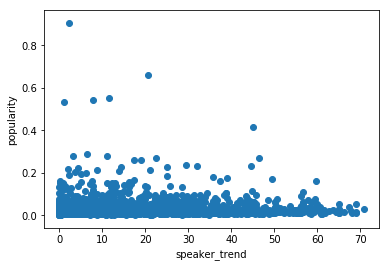

In [2]:
#df_ted.info()
#speaker_trend
#tags_trend
plt.scatter(df_ted['speaker_trend'], df_ted['popularity'])
plt.xlabel('speaker_trend')
plt.ylabel('popularity')
plt.show()
    

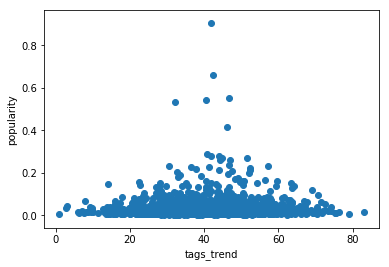

In [3]:
plt.scatter(df_ted['tags_trend'], df_ted['popularity'])
plt.xlabel('tags_trend')
plt.ylabel('popularity')
plt.show()

In [4]:
df_ted['speaker_trend'].corr(df_ted['popularity'])

0.048565033804218845

In [5]:
df_ted['tags_trend'].corr(df_ted['popularity'])

0.04833386084976522

In [6]:
#df_ted.info()

In [7]:
#  careate col random_popularity  with random values in range[0,2]
df_ted['Random_popularity'] = 0
import random
#
for i in range(2550):
    p =random.randint(0,2)
    df_ted.loc[i,'Random_popularity'] = p

In [8]:
# first par series and second  par array
import numpy as np
from sklearn.metrics import precision_score
x = df_ted['popularity_class']
y = np.array(df_ted['Random_popularity'])
#  compute precison of actual popularity class and Random  popularity           
acc = precision_score(x,y, average= 'micro')
acc

0.33647058823529413

In [9]:
type(df_ted['popularity_class'])

pandas.core.series.Series

In [10]:
df_ted['Random_popularity'].value_counts()

1    878
0    851
2    821
Name: Random_popularity, dtype: int64

### Random Forest

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

In [64]:
#df_ted.columns


In [134]:
attributes = ['duration', 'languages', 'num_speaker', 'Literature', 'Art' ,'Economy_Politics', 'Medicine',
             'Academy', 'Engineering_Science', 'Other_Occupations',
             'speaker_trend', 'tags_trend', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday',
              'funny_factor','TEDx', 'TED', 'TED_Global', 'TED_Other',
       'Non_TED_University', 'Non_TED_Other']
train_features = df_ted[attributes].values
train_target = df_ted['popularity_class']
# split train and test
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.50, 
                                                    random_state=40,stratify=y)

In [135]:
clf = RandomForestClassifier(n_estimators=10, 
                             criterion='gini',
                             max_features=None,
                             max_depth=30, 
                             min_samples_split=2,
                             min_samples_leaf=5,
                             bootstrap=True,
                             oob_score=False,
                             random_state=None,
                             class_weight=None) 

In [136]:
# train the data
classfier = clf.fit(train_x, train_y)

In [137]:
# predict on train data
prdict_train = classfier.predict(train_x)
# predict on test data
test_pred= classfier.predict(test_x)

In [138]:
print ('precsion on train: {0}'.format(metrics.precision_score(train_y, prdict_train, average = 'micro')))
print ('Test precsion: {0}'. format(metrics.precision_score(test_y, test_pred, average = 'micro')))

precsion on train: 0.8282352941176471
Test precsion: 0.5474509803921569


### Hyper Par. 

In [139]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [140]:
# creteria
criterion = ['entropy','gini']
# Number of trees in random forest
n_estimators = [int(x) for x in (10,100,10)]
# Number of features to consider at every split
max_features = [None,'auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# selecting samples for training each tree
bootstrap = [True, False]

In [141]:
random_grid = {'criterion': criterion ,'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [142]:
# instantiate RF object classfier
clf_par = RandomForestClassifier()

# Random search of parameters
clf_random = RandomizedSearchCV(estimator = clf_par, param_distributions = random_grid, 
                                n_iter=10, cv = 10,iid=True, scoring='precision_macro')

# fit the randomized search 
best_classfier = clf_random.fit(train_x, train_y)

In [143]:
best_classfier.best_params_ 

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': None,
 'max_depth': 100,
 'criterion': 'gini',
 'bootstrap': True}

In [144]:
#clf_random.cv_results_

In [145]:
# a function return the top three model parameters 
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [124]:
report(clf_random.cv_results_, 3) #search the top 3 best models


Model with rank: 1
Mean validation score: 0.630 (std: 0.088)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'entropy', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.629 (std: 0.076)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 3
Mean validation score: 0.618 (std: 0.075)
Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': None, 'max_depth': 50, 'criterion': 'entropy', 'bootstrap': True}



In [106]:
# predict on test
test_predictions = best_classfier.predict(test_x)
# predict on train data
train_pred= best_classfier.predict(train_x)
print ('Train Precsion: {0}'.format(metrics.precision_score(train_y, train_pred, average = 'micro')))
print ('Test precsion: {0}'. format(metrics.precision_score(test_y, test_predictions, average = 'micro')))
#evaluate_precision()

Train Precsion: 0.996078431372549
Test precsion: 0.5681372549019608


In [107]:
print(classification_report(test_y, 
                            test_predictions, 
                            target_names=['class 0', 'class 1', 'calss 2']))

              precision    recall  f1-score   support

     class 0       0.61      0.63      0.62       681
     class 1       0.44      0.46      0.45       674
     calss 2       0.67      0.61      0.64       685

    accuracy                           0.57      2040
   macro avg       0.57      0.57      0.57      2040
weighted avg       0.57      0.57      0.57      2040



### Feature Importance

In [108]:
# Model fitting and feature selection
for feature in zip(attributes, clf.feature_importances_):
    print(feature)

('duration', 0.1835133922216586)
('languages', 0.3291152490096412)
('num_speaker', 0.005745428062423396)
('Literature', 0.011384896349095832)
('Art', 0.005637167193597547)
('Economy_Politics', 0.018521302949366155)
('Medicine', 0.0)
('Academy', 0.0)
('Engineering_Science', 0.009247826405911647)
('Other_Occupations', 0.005812674379371336)
('speaker_trend', 0.09009233510798895)
('tags_trend', 0.09050184194257979)
('Monday', 0.002440108561424889)
('Tuesday', 0.013736065797864069)
('Wednesday', 0.004311041970922305)
('Thursday', 0.0010477612462966557)
('Friday', 0.003546330979707182)
('Saturday', 0.0)
('Sunday', 0.0)
('funny_factor', 0.19429805707115505)
('TEDx', 0.005980311368143027)
('TED', 0.011470560476498755)
('TED_Global', 0.0074123600267904715)
('TED_Other', 0.006185288879563331)
('Non_TED_University', 0.0)
('Non_TED_Other', 0.0)


### Model with Hyper_parm and features

In [129]:
#att = ['duration', 'languages', 'speaker_trend','tags_trend','funny_factor'] # 0.57
#att = ['languages']
#att = ['duration','speaker_trend']
train_features = df_ted[attributes].values
train_target = df_ted['popularity_class']
# split train and test
train_x, test_x, train_y, test_y = train_test_split(train_features, 
                                                    train_target, 
                                                    test_size=0.5, 
                                                    random_state=40,stratify=y)

In [132]:
clf_b = RandomForestClassifier(n_estimators=100, 
                             criterion='entropy',
                             max_features= 'auto',
                             max_depth=110, 
                             min_samples_split=10,
                             min_samples_leaf=1,
                             bootstrap=False)
                            
# train the data
classfier = clf_b.fit(train_x, train_y)
# predict on train data
prdict_train = classfier.predict(train_x)
# predict on test data
test_pred= classfier.predict(test_x)
print ('precsion on train: {0}'.format(metrics.precision_score(train_y, prdict_train, average = 'micro')))
print ('Test precsion: {0}'. format(metrics.precision_score(test_y, test_pred, average = 'micro')))

precsion on train: 0.9984313725490196
Test precsion: 0.5576470588235294


### Cross Val

In [133]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report
#scores = cross_validation.cross_val_score(classfier, train_feature, train_target, cv=10)
scores = cross_val_score(classfier, train_features, train_target, cv=10,scoring='precision_macro')
scores

array([0.56713559, 0.5521075 , 0.51513304, 0.47603289, 0.60537131,
       0.56088092, 0.60283176, 0.52339286, 0.59124664, 0.5691584 ])